# Flavours of parallelism plus multithreading using the MKL

Covers: - multithreaded linear algebra with Numpy+MKL (easy win)

* ?

SPEEDING THINGS UP:
- USED TO HAVE UPWARD TREND IN SPEED AT WHICH PROCESSORS COULD PROCESS INSTRUCTIONS ('CLOCK SPEED')
- LITTLE IMPROVEMENT IN THIS 'CLOCK SPEED' IN RECENT YEARS.
- SO HOW CAN WE MAKE OUR CODE GO FASTER?  CAN'T BUY SIGNIFICANTLY FASTER PROCESSOR FOR LOVE NOR MONEY.
- ONE APPROACH IS TO DO MULTIPLE CHUNKS OF WORK AT ONCE.  
  - DISTRIBUTE WORK BETWEEN PROCESSING CORES OF ONE OR MORE CPUS IN ONE MACHINE
  - DISTRIBUTE WORK BETWEEN CPU CORES IN MULTIPLE MACHINES

TYPES OF PARALLELISM 
- SHARED MEM VS DISTRIBUTED MEM (DIAGS)
- SHARED MEM: SINGLE PROC, MULT THREADS, SINGLE GLOBAL ADDRESS SPACE.  ONE NODE.
- DISTR MEM: MULT PROC, EACH HAS ONE (OR MORE?) THREADS, ADDRESS SPACE PER PROCESSOR, ONE OR MORE NODES.  PROCS COMMUNICATE BY PASSING MESSAGES WITHIN MACHINE / BETWEEN MACHINES.
- PYTHON CAN ONLY EFFICIENTLY HANDLE DISTRIBUTED MEM PARALLELISATION AS TWO PYTHON THREADS CANNOT DO COMPUTATION AT THE SAME TIME DUE TO DESIGN OF PYTHON INTERPRETER. 

EASE OF PARALLELISING PROBLEMS
- SIMPLEST IF PARALLEL TASKS ARE INDEPENDENT (NO COMMUNICATION BETWEEN TASKS WHILST RUNNING) - EMBARASSINGLY PARALLEL
- THINGS GET MORE COMPLEX IF TASKS NEED TO COMMUNICATE.  NATURE OF COMPLEXITY DIFFERS FOR SM VS DM. 





WHAT IS MKL?
WHAT IS BLAS/LAPACK?
WHY USEFUL FOR NUMPY?
NB NEED TO USE CONDA TO GET MKL-AWARE NUMPY

NB APOLOGIES IF YOU DON'T DO MUCH WORK WITH ARRAYS/MATRICES - FOLLOWING MAY NOT BE OF INTEREST!

In [68]:
import os
import numpy as np
import scipy.linalg
import matplotlib.pyplot as plt
import mkl  # provided by mkl-service package

plt.style.use('ggplot')
%matplotlib inline

In [58]:
x = np.random.random_sample((1000, 1000))
y = np.random.random_sample((1000, 1000))
x[:5, :5]

array([[0.29827115, 0.01257549, 0.85900668, 0.4135302 , 0.94120785],
       [0.46164421, 0.85249818, 0.95709111, 0.63019117, 0.56369667],
       [0.21856467, 0.08446137, 0.75837615, 0.07405838, 0.95380444],
       [0.94157857, 0.83879875, 0.33514032, 0.33935266, 0.29757601],
       [0.58183237, 0.88760404, 0.15726526, 0.38853611, 0.37466679]])

In [60]:
thread_cnts = np.arange(1, 5)
timings_mean = []
timings_stdev = []

for i in thread_cnts:
    mkl.set_num_threads(i)
    timings = %timeit -o x @ y
    timings_mean.append(timings.average)
    timings_stdev.append(timings.stdev)

40.5 ms ± 383 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
22.4 ms ± 103 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
16.5 ms ± 460 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
13.9 ms ± 95.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


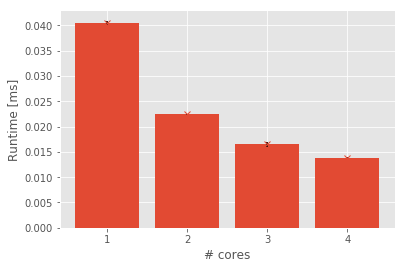

In [61]:
fig, ax = plt.subplots()
ax.errorbar(x=thread_cnts, y=timings_mean, yerr=timings_stdev, fmt='x');
ax.bar(thread_cnts, timings_mean, yerr=timings_stdev)
ax.set_xticks(thread_cnts)
ax.set_xticklabels(thread_cnts)
ax.set_xlabel('# cores')
ax.set_ylabel('Runtime [ms]');

NOT LINEAR SPEEDUP WHEN INCREASE CORES

AHMDAHL'S LAW

NEED TO DECIDE FOR YOURSELF WHETHER USING MORE CORES IS WORTH IT.

RUN TESTS LIKE THE ABOVE WITH SUBSET OF PROGRAM TO SEE HOW THE PROBLEM SCALES TO MORE CORES

---
OTHER LIBRARIES CAN USE MKL TOO, EITHER BY DEPENDING ON NUMPY OR BY USING MKL DIRECTLY E.G. SCIPY

In [70]:
z = np.random.random_sample((1000, 80))

thread_cnts = np.arange(1, 5)
timings_mean = []
timings_stdev = []

for i in thread_cnts:
    mkl.set_num_threads(i)
    timings = %timeit -o scipy.linalg.svd(z)
    timings_mean.append(timings.average)
    timings_stdev.append(timings.stdev)

21.6 ms ± 664 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
16.3 ms ± 416 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
14.4 ms ± 285 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
13.4 ms ± 249 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


BEST TO USE UP TO AS MANY THREADS AS AVAILABLE CPU CORES: USE MORE THAN THAT AND SOME THREADS WILL BE FORCED TO SPEND SOME TIME WAITING, WHICH IS INEFFICIENT USE OF CORES

In [72]:
z = np.random.random_sample((1000, 80))

thread_cnts = np.arange(1, 16, 4)
timings_mean = []
timings_stdev = []

for i in thread_cnts:
    mkl.set_num_threads(i)
    timings = %timeit -o scipy.linalg.svd(z)
    timings_mean.append(timings.average)
    timings_stdev.append(timings.stdev)

20.8 ms ± 268 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
12.2 ms ± 92 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
12.3 ms ± 291 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
12.2 ms ± 140 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


WHY NOT USE ALWAYS USE AS MANY THREADS AS AVAILABLE CORES?  SOMETIMES MAY WANT TO LIMIT MKL THREADS SO CAN HAVE MULTIPLE PROCESSES RUNNING AT ONCE THAT DON'T INTERFERE WITH EACH OTHER. (DIAG)